# Investments Project (Spring 2024)

**Authors:**
- Marc-Antoine Allard
- Adam Zinebi
- Paul Teiletche
- ...

**DUE Date: June 21 at 23:59**

---
# Imports

In [16]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime
#import wrds
import seaborn as sns
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm



---
# Load the data

In [28]:
# Complete data
data = pd.read_parquet("../data/stock_data.parquet")

# Part 3 data (BAB
data_bab = pd.read_parquet("../data/stock_data_part1.parquet")

In [29]:
data.head()

,permno,date,Rn,shrout,prc,siccd,Rm,rf,mcap,mcap_l,Rn_f,const,Rn_e,Rm_e,w_m
5,10001,2010-01-29,-0.018932,4361.0,10.0600,4925,-0.037172,0.000013,43871.6600,44918.3000,-0.000656,1,-0.018945,-0.037185,0.000005
4,10001,2010-02-26,-0.000656,4361.0,10.0084,4925,0.034744,0.000061,43646.6324,43871.6600,0.020643,1,-0.000717,0.034683,0.000005
3,10001,2010-03-31,0.020643,4361.0,10.1700,4925,0.063668,0.000112,44351.3700,43646.6324,0.124385,1,0.020531,0.063556,0.000005
2,10001,2010-04-30,0.124385,6070.0,11.3900,4925,0.020036,0.000118,69137.3000,44351.3700,0.004829,1,0.124267,0.019918,0.000004
1,10001,2010-05-28,0.004829,6071.0,11.4000,4925,-0.079240,0.000114,69209.4000,69137.3000,-0.043421,1,0.004715,-0.079354,0.000007


In [30]:
data['date'] = pd.to_datetime(data['date'])  
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1425495 entries, 5 to 1437180
Data columns (total 15 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   permno  1425495 non-null  int64         
 1   date    1425495 non-null  datetime64[ns]
 2   Rn      1425495 non-null  float64       
 3   shrout  1425495 non-null  float64       
 4   prc     1425495 non-null  float64       
 5   siccd   1425495 non-null  int64         
 6   Rm      1425495 non-null  float64       
 7   rf      1425495 non-null  float64       
 8   mcap    1425495 non-null  float64       
 9   mcap_l  1425495 non-null  float64       
 10  Rn_f    1415474 non-null  float64       
 11  const   1425495 non-null  int64         
 12  Rn_e    1425495 non-null  float64       
 13  Rm_e    1425495 non-null  float64       
 14  w_m     1425495 non-null  float64       
dtypes: datetime64[ns](1), float64(11), int64(3)
memory usage: 174.0 MB


---
# Idiosyncratic Volatility Strategy (IV)

(a) Compute the time-varying estimate for each stock’s idiosyncratic volatility $ σ^{idio}_{t,n} $ obtained as the volatility of the residual in the monthly rolling 5-year regressions of
stock-specific excess returns on the excess market return. Require at least 36 months
of observations for each stock. Winsorize the volatility at 5 and 95 %.

In [31]:
# Remove any potential NaN values
data = data.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

# Remove rare stocks with less than 60 observations
data['N'] = data.groupby(['permno'])['date'].transform('count')
data = data[data['N']>60].copy()

# Calculate the rolling covariance matrix
cov_nm = data.set_index('date').groupby('permno')[['Rn_e', 'Rm_e']].rolling(60, min_periods=36).cov()

# Extract the required components
cov_ee = cov_nm.iloc[0::2, 0].droplevel(2)
cov_em = cov_nm.iloc[1::2, 0].droplevel(2)
cov_mm = cov_nm.iloc[1::2, 1].droplevel(2)

# Calculate rolling beta
beta = cov_em / cov_mm

# Calculate idiosyncratic variance
idio_variance = cov_ee - beta**2 * cov_mm

# Calculate idiosyncratic volatility as the square root of idiosyncratic variance
idio_volatility = np.sqrt(idio_variance)

# Add the idiosyncratic volatility to the original dataframe
data = data.set_index(['permno', 'date'])
data['sigma_idio'] = idio_volatility

# Reset index to merge correctly
data = data.reset_index()

# Winsorize the idiosyncratic volatility at 5% and 95%
data['sigma_idio'] = data['sigma_idio'].clip(lower=data['sigma_idio'].quantile(0.05), upper=data['sigma_idio'].quantile(0.95))


- Look up on the volatilities

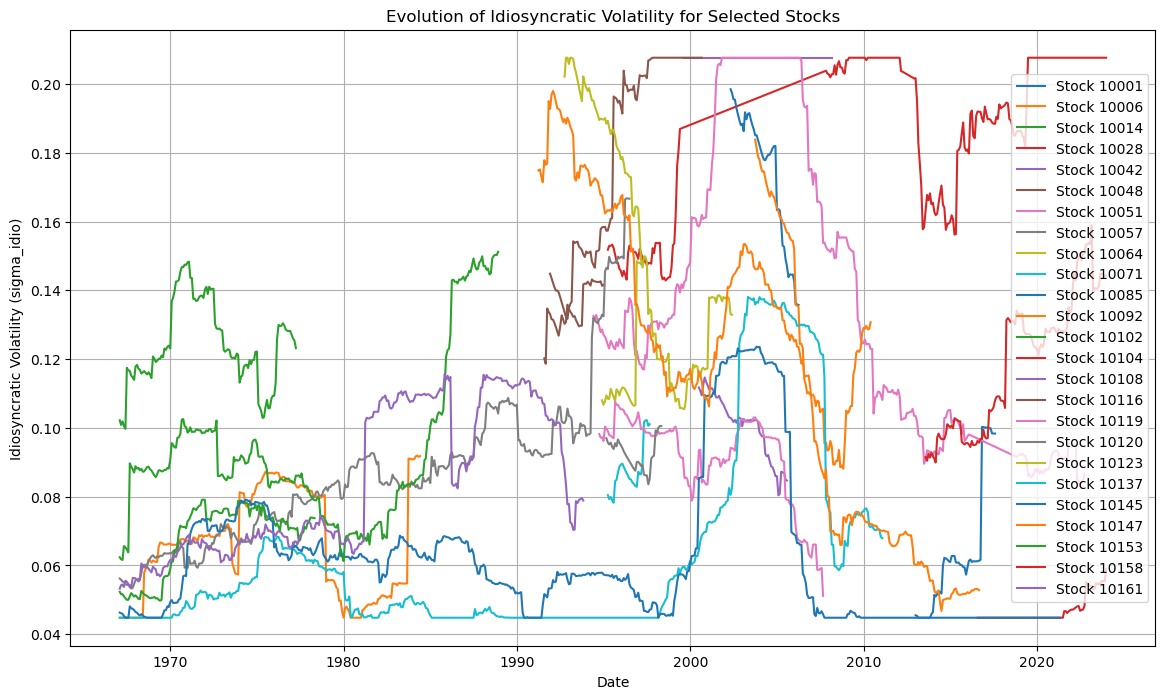

In [41]:
# Select five unique stocks for plotting
selected_stocks = data['permno'].unique()[:25]

# Filter data for the selected stocks
filtered_data = data[data['permno'].isin(selected_stocks)]

# Plot the idiosyncratic volatility over time for each selected stock
plt.figure(figsize=(14, 8))
for stock in selected_stocks:
    stock_data = filtered_data[filtered_data['permno'] == stock]
    plt.plot(stock_data['date'], stock_data['sigma_idio'], label=f'Stock {stock}')

plt.title('Evolution of Idiosyncratic Volatility for Selected Stocks')
plt.xlabel('Date')
plt.ylabel('Idiosyncratic Volatility (sigma_idio)')
plt.legend()
plt.grid(True)
plt.show()

(b) At every month t, sort all stocks into deciles based on their idiosyncratic volatility
(estimated using the most recent rolling window). Then compute monthly returns for
10 decile portfolios that equal weight all stocks in each decile. Plot the average annu-
alized portfolio mean, standard deviation, and Sharpe ratios across the 10 deciles in
three barplots. Repeat for value-weighted decile portfolios. Summarize your findings.
Is the evidence consistent with the CAPM?

In [42]:
# Sort stocks into deciles based on idiosyncratic volatility at each month
data = data.dropna(subset=['sigma_idio']).copy()
data['sigma_idio_decile'] = data.groupby('date')['sigma_idio'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

# Compute market weights within deciles
data['vw_Q'] = data['mcap_l'] / data.groupby(['date', 'sigma_idio_decile'])['mcap_l'].transform('sum')

# Compute value-weighted returns for each decile
data['idio_ret_vw'] = data['vw_Q'] * data['Rn_e']
ret_vw = data.groupby(['date', 'sigma_idio_decile'])['idio_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('sigma_idio_decile')['idio_ret_vw'].mean()

# Compute equal-weighted returns for each decile
ret_ew = data.groupby(['date', 'sigma_idio_decile'])['Rn_e'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('sigma_idio_decile')['Rn_e'].mean()

# Convert to DataFrame for plotting
vw_ret = pd.DataFrame((vw_ret_mean * 12).to_list(), columns=['mean vw return'], index=['D' + str(x) for x in np.arange(1, 11)])
ew_ret = pd.DataFrame((ew_ret_mean * 12).to_list(), columns=['mean ew return'], index=['D' + str(x) for x in np.arange(1, 11)])

In [51]:
# Calculate annualized portfolio statistics
def calculate_stats(returns):
    mean_return = returns.mean() * 12
    std_dev = returns.std() * np.sqrt(12)
    sharpe_ratio = mean_return / std_dev
    return mean_return, std_dev, sharpe_ratio

# Compute value-weighted portfolio statistics
vw_stats = ret_vw.groupby('sigma_idio_decile').apply(lambda x: calculate_stats(x['idio_ret_vw']))

# Compute equal-weighted portfolio statistics
ew_stats = ret_ew.groupby('sigma_idio_decile').apply(lambda x: calculate_stats(x['Rn_e']))

/var/folders/gx/b0gl84xd4rjflbpgs2bhddcc0000gp/T/ipykernel_69638/1795134258.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vw_stats = ret_vw.groupby('sigma_idio_decile').apply(lambda x: calculate_stats(x['idio_ret_vw']))
/var/folders/gx/b0gl84xd4rjflbpgs2bhddcc0000gp/T/ipykernel_69638/1795134258.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ew_stats = ret_ew.groupby('sigma_idio_decile').apply(la

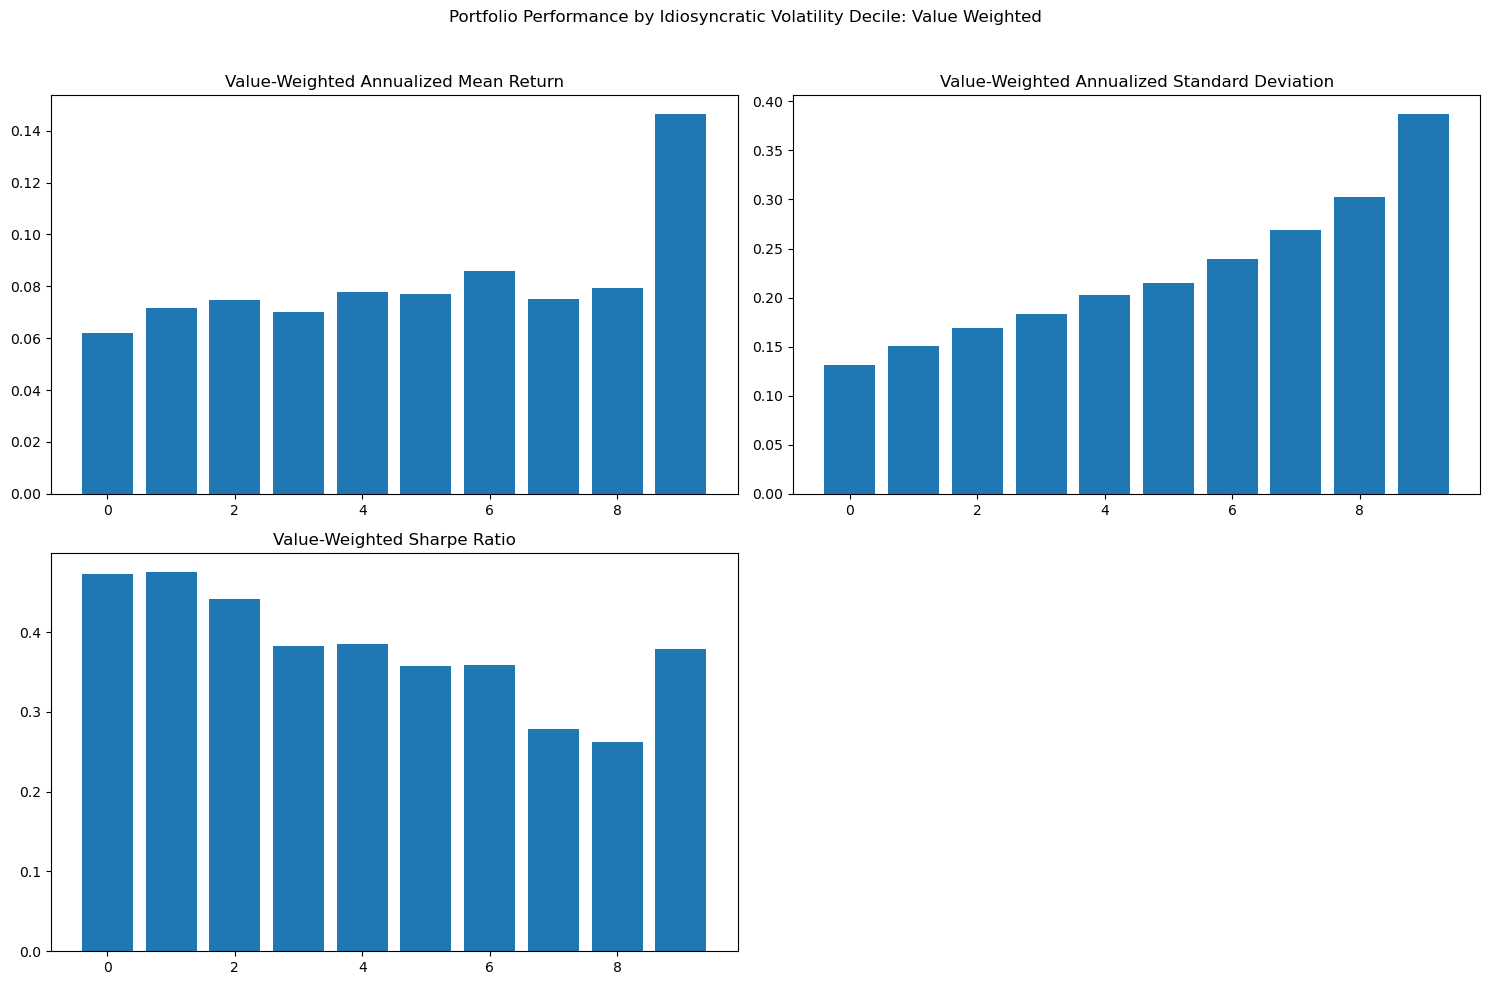

In [52]:
# Plot decile Val weighted
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Portfolio Performance by Idiosyncratic Volatility Decile: Value Weighted')

# Value-Weighted Portfolios
axes[0, 0].bar(vw_stats.index, vw_stats.apply(lambda x: x[0]))
axes[0, 0].set_title('Value-Weighted Annualized Mean Return')

axes[0, 1].bar(vw_stats.index, vw_stats.apply(lambda x: x[1]))
axes[0, 1].set_title('Value-Weighted Annualized Standard Deviation')

axes[1, 0].bar(vw_stats.index, vw_stats.apply(lambda x: x[2]))
axes[1, 0].set_title('Value-Weighted Sharpe Ratio')


# Hide the fourth subplot
axes[1, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

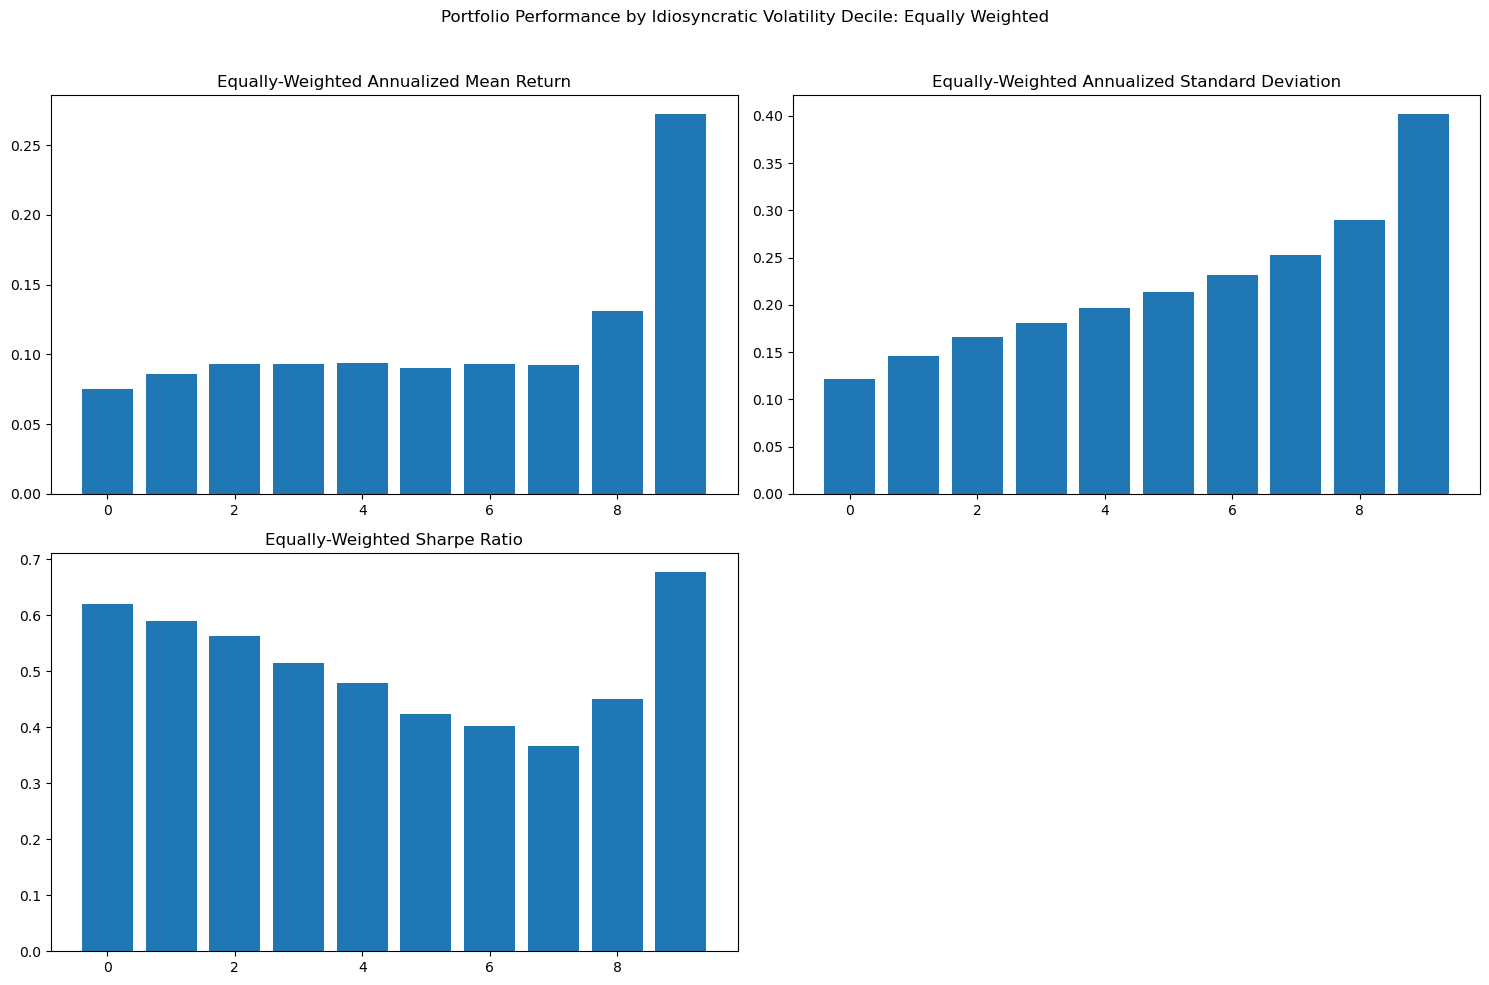

In [53]:
# Plot decile Equal weighted
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Portfolio Performance by Idiosyncratic Volatility Decile: Equally Weighted')

# Equally-Weighted Portfolios
axes[0, 0].bar(ew_stats.index, ew_stats.apply(lambda x: x[0]))
axes[0, 0].set_title('Equally-Weighted Annualized Mean Return')

axes[0, 1].bar(ew_stats.index, ew_stats.apply(lambda x: x[1]))
axes[0, 1].set_title('Equally-Weighted Annualized Standard Deviation')

axes[1, 0].bar(ew_stats.index, ew_stats.apply(lambda x: x[2]))
axes[1, 0].set_title('Equally-Weighted Sharpe Ratio')

# Hide the fourth subplot
axes[1, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

*Findings*:

- Indeed there is strong evidence that it is consistent with the CAPM, 

(c) Now we construct the idiosyncratic volatility factor. At every month t, we go long
the three highest decile volatility portfolios and we go short the three lowest decile
volatility portfolios. Compute and compare the mean, standard deviation, and Sharpe
ratios of the long and short legs of the strategy as well as of the strategy itself. Test if
the strategy has an average return that is statistically significantly different from zero.
Repeat both tests for equal and value-weighted portfolios. How do your results differ
from Ang, Hodrick, Xing, and Zhang (2006; table VI page 285) and what may be the
explanation for the difference?